# Projet numérique de Mathématiques - Calcul Différentiel 2

## Introduction

On souhaite tracer les lignes de niveau d'une fonction à deux variables et à valeur réelle. C'est à dire trouver une partie significative des points de l'ensemble suivant:
$\{(x,y) \in \mathbf{R}^2 | f(x,y) = c\} où c \in \mathbf{R}$

## Contour simple

### Amorce

Ici, on se place sur l'arrête gauche du cadre de tracé. On fixe alors $x = 0$ et on peut définir: $\begin{array}{ccccc}
g & : & \mathbf{R} & \to & \mathbf{R} \\
 & & y & \mapsto & f(0, y) \\
\end{array}$

On sait que g est dérivable et de dérivée continue d'après les propriétés de différentiabilité de f. Ainsi, en utilisant le Théorème des valeurs intermédiaires, on a directement que si $g(0) \leq c \leq g(1)$ ou bien $g(1) \leq c \leq g(0)$, alors il existe $t \in [0,1]$ tel que $g(t) = c$

### Module 

Voici les modules utilisés dans le script:

In [21]:
import autograd
from autograd import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### Fonction find_seed

On utilise une méthode de dichotomie. En effet, on compare f évaluée en un point milieu par rapport à c pour continuer à valider la condition précédente. Et ainsi de suite jusqu'à arriver à un intervalle de taille suffisemment petite.

In [22]:
def find_seed(g,c=0,eps=2**(-26)):
    '''Propose un t qui convient si c'est possible'''
    a=0
    b=1
    if (g(a)-c)*(g(b)-c)>0:    #Si la condition précédente n'est pas vérifée
        return None
    while (b-a)>eps:    #Méthode dichotomique
        t=(b+a)/2
        if (g(a)-c)*(g(t)-c)<=0:
            b=t
        else:
            a=t
    return t

### Propagation: simple_contour

Tout d'abord, on se rapporte à des carrés de côtés unitaires et on suppose que la courbe entre par le côté gauche, de manière à trouver un premier point à tracer grâce à find_seed. Ensuite, on calcule le gradient de la fonction à l'aide ce qui suit:

In [23]:
def gradient(f,x,y):
    '''Calcule le gradient de f en (x,y)'''
    g=autograd.grad
    return np.r_[g(f,0)(x,y),g(f,1)(x,y)]

On en déduit un vecteur directeur de la droite tangente à la courbe bien orienté (grâce au deuxième if). On norme ce vecteur et on le multiplie par la distance delta maximale demandée.

In [24]:
def simple_contour(f,c=0,delta=0.01):
    '''Donne les coordonnées demandées sur un cadre de côté unitaire'''
    x=np.array([])
    y=np.array([])
    eps=2**(-26)
    gamma = delta / math.sqrt(2)
    def g(x):
        return (f(0,x))
    if find_seed(g,c)==None:
        return x,y
    y = np.append(y, np.array([find_seed(g,c)]))

    x = np.append(x, np.array([0]))

    grad=gradient(f,x[-1],y[-1])
    tang=[-grad[1],grad[0]]
    print(tang)
    if tang[0]<0:
        tang=[grad[1],-grad[0]]
        while x[-1] <= 1 and y[-1] <= 1 and x[-1] >= 0 and y[-1] >= 0:
            grad=gradient(f,x[-1],y[-1])
            tang=[grad[1],-grad[0]]
            norme=math.sqrt(tang[0]**2+tang[1]**2)
            x = np.append(x, np.array(x[-1]+(delta*tang[0])/(norme)))
            y = np.append(y, np.array(y[-1]+(delta*tang[1])/(norme)))
    else:
        tang=[-grad[1],grad[0]]
        while x[-1] <= (1) and y[-1] <= (1) and x[-1] >= 0 and y[-1] >= 0:
            grad=gradient(f,x[-1],y[-1])
            tang=[-grad[1],grad[0]]
            norme=math.sqrt(tang[0]**2+tang[1]**2)
            x = np.append(x, np.array(x[-1]+(delta*tang[0])/(norme)))
            y = np.append(y, np.array(y[-1]+(delta*tang[1])/(norme)))
    return x,y

#### Premier tracé: la fonction du sujet

In [25]:
def f(x,y):
    '''Fonction dont on veut tracer le graphe'''
    return 2*( np.exp(-x**2-y**2)- np.exp(-(x-1)**2 - (y-1)**2))

[2.0895076707781244, -1.364410742138914]
[2.0895076707781244, -1.364410742138914]


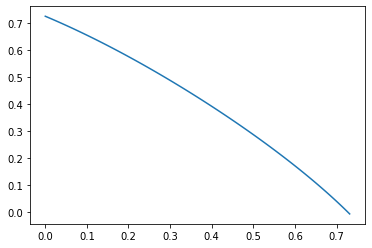

In [26]:
plt.plot(simple_contour(f,0.5,)[0],simple_contour(f,0.5,)[1])
plt.show()

#### Optimisation

Ainsi, on a une bonne approximation du point suivant qui respecte en partie les conditions de tracé.
En effet, on utilise une méthode inspirée de la méthode d'Euler pour les équations différentielles, qui peut présenter un fort phénomène de dérive.
Pour affiner le tracé précédent, on décide d'appliquer la méthode de Newton à une fonction $F$ de $\mathbf{R}^2$ dans $\mathbf{R}^2$ bien choisie:

In [27]:
def F(x, y, x0, y0, c, delta):
    '''Fonction F pour la méthode de Newton'''
    return np.array([f(x,y) - c, (x-x0)**2 + (y-y0)**2 - delta**2])

On remplace alors la dérivée par la jacobienne:

In [28]:
def J_F(x, y):
    '''Jacobienne de F'''
    j = autograd.jacobian
    return np.c_[j(F, 0)(x, y), j(F, 1)(x, y)]

### Nouvelle fonction: simple_contour optimisée

## Contour complexe

### Fonctions de rotation des carrés unitaires

In [29]:
# Rotators
# ------------------------------------------------------------------------------
LEFT, UP, RIGHT, DOWN = 0, 1, 2, 3  # clockwise


def rotate_direction(direction, n=1):
    return (direction + n) % 4


def rotate(x, y, n=1):
    if n == 0:
        return x, y
    elif n >= 1:
        return rotate(1 - y, x, n - 1)
    else:
        assert n < 0
        return rotate(x, y, n=-3 * n)


def rotate_function(f, n=1):
    def rotated_function(x, y):
        xr, yr = rotate(x, y, -n)
        return f(xr, yr)

    return rotated_function

### Fonction contour

In [38]:
# Complex Contouring
# ------------------------------------------------------------------------------

# Customize the simple_contour function used in contour :
# simple_contour = smart_simple_contour


def contour(f, c, xs=[0.0, 1.0], ys=[0.0, 1.0], delta=0.01):
    curves = []
    nx, ny = len(xs), len(ys)
    for i in range(nx - 1):
        for j in range(ny - 1):
            xmin, xmax = xs[i], xs[i + 1]
            ymin, ymax = ys[j], ys[j + 1]

            def f_cell(x, y):
                return f(xmin + (xmax - xmin) * x, ymin + (ymax - ymin) * y)

            done = set()
            for n in [0, 1, 2, 3]:
                if n not in done:
                    rotated_f_cell = rotate_function(f_cell, n)
                    x_curve_r, y_curve_r = simple_contour(rotated_f_cell, c, delta)
                    exit = None
                    if len(x_curve_r) >= 1:
                        xf, yf = x_curve_r[-1], y_curve_r[-1]
                        if xf == 0.0:
                            exit = LEFT
                        elif xf == 1.0:
                            exit = RIGHT
                        elif yf == 0.0:
                            exit = DOWN
                        elif yf == 1.0:
                            exit = UP
                    if exit is not None:  # a fully successful contour fragment
                        exit = rotate_direction(exit, n)
                        done.add(exit)

                    x_curve, y_curve = [], []
                    for x_r, y_r in zip(x_curve_r, y_curve_r):
                        x, y = rotate(x_r, y_r, n=-n)
                        x_curve.append(x)
                        y_curve.append(y)
                    x_curve = np.array(x_curve)
                    y_curve = np.array(y_curve)
                    curves.append(
                        (xmin + (xmax - xmin) * x_curve, ymin + (ymax - ymin) * y_curve)
                    )
    return curves

### Tracés finaux

[0.026951785586664317, 0.026951787996341847]
[-0.026951790406019565, 0.026951787996341847]
[9.041318975185604e-06, -9.041317627924193e-06]
[9.041318975185604e-06, 9.041317627924193e-06]
[-0.026951785586664317, 0.026951787996341847]
[-0.026951785586664317, -0.026951787996341847]
[1.471517720831122, 1.471517764685769]
[-1.471517808540416, 1.471517764685769]
[0.026951790406019565, -0.026951787996341847]
[0.026951790406019565, 0.026951787996341847]
[-1.471517720831122, 1.471517764685769]
[-1.471517720831122, -1.471517764685769]
[0.026951785586664317, -0.026951787996341847]
[-0.026951790406019565, -0.026951787996341847]
[1.471517808540416, 1.471517764685769]
[-1.471517720831122, 1.471517764685769]
[1.471517808540416, -1.471517764685769]
[1.471517808540416, 1.471517764685769]
[-1.471517808540416, 1.471517764685769]
[-1.471517808540416, -1.471517764685769]
[1.471517720831122, -1.471517764685769]
[-1.471517808540416, -1.471517764685769]
[0.026951790406019565, 0.026951787996341847]
[-0.02695178

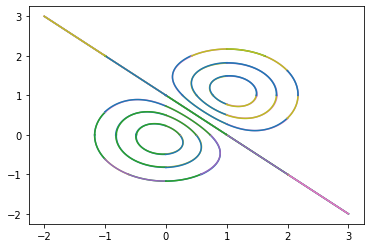

In [44]:
a = [0.0, 0.5, 1.5, 1.0, -1.5, -1.0, -0.5]
for i in a:
    resultats = contour(f, i,[-2.0,-1.0,0.0,1.0,2.0,3.0],[-2.0,-1.0,0.0,1.0,2.0,3.0])
    for x, y in resultats:
        plt.plot(x, y, i)
plt.show()

[0.026951785586664317, 0.026951787996341847]
[-0.026951790406019565, 0.026951787996341847]
[1.471517720831122, 1.471517764685769]
[-1.471517808540416, 1.471517764685769]
[0.026951790406019565, -0.026951787996341847]
[0.026951790406019565, 0.026951787996341847]
[-1.471517720831122, 1.471517764685769]
[-1.471517720831122, -1.471517764685769]
[1.471517808540416, 1.471517764685769]
[-1.471517720831122, 1.471517764685769]
[1.471517808540416, -1.471517764685769]
[1.471517808540416, 1.471517764685769]
[-1.471517808540416, 1.471517764685769]
[-1.471517808540416, -1.471517764685769]
[1.471517720831122, -1.471517764685769]
[-1.471517808540416, -1.471517764685769]
[1.471517720831122, -1.471517764685769]
[1.471517720831122, 1.471517764685769]
[-0.026951790406019565, 0.026951787996341847]
[-0.026951790406019565, -0.026951787996341847]
[1.471517808540416, -1.471517764685769]
[-1.471517720831122, -1.471517764685769]
[0.026951790406019565, -0.026951787996341847]
[-0.026951785586664317, -0.026951787996

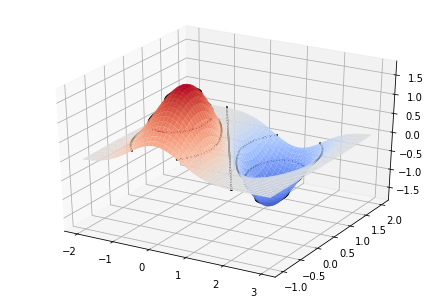

In [41]:
a = [0.0, 0.5, 1.5, 1.0, -1.5, -1.0, -0.5]


p = np.linspace(-2,3,100)
q =  np.linspace(-1,2,100)

X, Y = np.meshgrid(p,q)

Z = f(X,Y)

fig = plt.figure() 
 
ax = Axes3D(fig)
ax.plot_surface(X, Y, Z, cmap='coolwarm'); #On trace le graphe de la fonction
for i in a: #On trace différentes lignes de niveau en noir
    resultats = contour(f, i,[-2.0,-1.0,0.0,1.0,2.0,3.0],[-1.0,0.0,1.0,2.0])
    for x, y in resultats:
        ax.plot(x, y,i, color = 'black')

plt.show()

## Autres pistes

Nous avons testé d'utiliser find_seed en le translatant de $\Delta x$ par rapport à x, $\Delta x$ étant suffisemment petit pour respecter les conditions de tracé:

In [45]:
def simple_contour_essai(f,c=0,delta=0.01):
    x=[]
    y=[]
    x0=0
    g=lambda x:f(x0,x)
    if find_seed(g,c)==None:
        return x,y
    y.append(find_seed(g,c))
    x.append(0)
    y0=y[0]
    while x0<1 and 0<y[-1]<1 :
        pas=0.005
        x1=x0+pas
        g=lambda x:f(x1,x)
        temps=find_seed(g,c)
        while pas**2+(temps-y0)**2>delta**2:
            pas=pas/2
            x1=x0+pas
            g=lambda x:f(x1,x)
            temps=find_seed(g,c)
        x.append(x1)
        x0=x1
        y.append(temps)
    return x,y 

Nous avons également tenté de parcourir un cercle de rayon delta autour du dernier point. En découpant ce cercle en un grand nombre de points (grosse complexité), on voulait arriver à trouver le point. On utilise donc le principe de dichotomie angulaire, malheureusement, nous avons été déconseillé de réaliser cela rapidement:

In [46]:
def dichoang(f,x,y,delta,eps=2**(-26)):
    g=grad(f,x,y)
    t=[-g[1],g[0]]
    a=-math.pi
    b=math.pi
    while (b-a)>eps:
        c=(a+b)/2
        if f()...

SyntaxError: invalid syntax (<ipython-input-46-64f1838ebb5e>, line 8)